In [5]:
import os, sys, json
import pandas as pd
import matplotlib.pyplot as plt
import torch
import pickle as pkl
from captum.attr import LayerIntegratedGradients, TokenReferenceBase, visualization, IntegratedGradients
from models.GCNNet import GCNNet
import scipy.sparse as sp
from torch_geometric.data import Data
import numpy as np

dataset = 'mr'
vocab = list([line.strip() for line in open(f'../data/{dataset}/raw/{dataset}_vocab.txt').readlines()])
word_id_map = {vocab[i] : i for i in range(len(vocab))}
id_word_map = {i : vocab[i] for i in range(len(vocab))}

docs = list([line.strip() for line in open(f'../data/{dataset}/raw/{dataset}.clean.txt').readlines()])
doc_metas = list([line.strip() for line in open(f'../data/{dataset}/raw/{dataset}.txt').readlines()])
doc_labels = list(set([doc_meta.split('\t')[2] for doc_meta in doc_metas]))
label_id_map = {doc_labels[i]: i for i in range(len(doc_labels))}
train_set = [[docs[i], label_id_map[doc_metas[i].split('\t')[-1]]] for i in range(len(docs)) if doc_metas[i].split('\t')[1].find('train') != -1]
test_set = [[docs[i], label_id_map[doc_metas[i].split('\t')[-1]]] for i in range(len(docs)) if doc_metas[i].split('\t')[1].find('test') != -1]
train_size = len(train_set)
test_size = len(test_set)
doc_size = len(docs)
vocab_size = len(vocab)
node_size = len(vocab) + len(docs)
labels = torch.tensor([item[1] for item in train_set] + [item[1] for item in test_set] + [-1] * vocab_size)

datasets = 'mr'

In [40]:

def predict(x, edge_index, edge_attr):
    return model(x, edge_index, edge_attr)
    
def text_gcn_forward_func(x, edge_index, edge_attr, docid=0):
    pred = predict(x, edge_index, edge_attr)
    pred = pred[docid]
    return pred

def get_tokens_by_docid(id):
    assert id < len(docs), 'invlaid id'
    tokens = docs[id].split()
    token_ids = [word_id_map[word] for word in tokens]
    if id < len(test_set):
        label = train_set[id][1]
    else:
        label = test_set[id - len(train_set)][1]
    return tokens, token_ids, label
        
def forward_with_sigmoid(x, edge_index, edge_attr, docid):
    return torch.sigmoid(text_gcn_forward_func(x, edge_index, edge_attr, docid))




def plot_with_networkx(node_indexes, node_texts, node_weights):
    import networkx as nx
    import matplotlib.pyplot as plt
    # 解决图像中的中文乱码问题
    plt.rcParams['font.sans-serif'] = ['SimHei'] 
    plt.rcParams['font.family']='sans-serif'

    g = nx.DiGraph();
    g.clear();
    
    for i, index in enumerate(node_indexes):
        for neighbor, weight in enumerate(adj[index]):
            if neighbor in node_indexes and neighbor != index:
                g.add_edge(f"{node_weights[i]}:{node_texts[i]}", f"{node_weights[node_indexes.index(neighbor)]}:{node_texts[node_indexes.index(neighbor)]}", weight=weight)
    print(g);
    print(g.nodes())
    print(g.nodes().data()) # 显示边的数据
    print(g.edges().data())

    pos=nx.spring_layout(g);
    nx.draw_spring(g,with_labels=True); # 显示节点的名称
    nx.draw_networkx_edge_labels(g,pos,font_size=14,alpha=0.5,rotate=True); 

    plt.axis('off')
    plt.show()

def add_attributions_to_visualizer(attributions, text, token_ids, pred, pred_ind, label, delta, vis_data_records, top_k=10):
    attributions = attributions.sum(dim=2).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    attributions = attributions.cpu().detach().numpy()
    node_ids = [id + len(docs) for id in token_ids]
    tokens_attributions = attributions[node_ids]
    sorted_index = np.argsort(-attributions)
    top_k_index = sorted_index[:top_k]
    other_tokens_index = np.array([index for index in top_k_index if index >= doc_size])
    doc_index = np.array([index for index in top_k_index if index < doc_size])
    doc_attributions = {docs[index]: float(attributions[index]) for index in doc_index}
    other_tokens_attributions = {id_word_map[index - doc_size]: float(attributions[index]) for index in other_tokens_index if index not in node_ids}
    print('all tokens with attributions in this doc')
    print(json.dumps({token: float(attribution) for token, attribution in zip(text, tokens_attributions)}, indent=4, ensure_ascii=False))
    print(f'other words -{len(other_tokens_attributions)}- and attribution in top 100 nodes')
    print(json.dumps(other_tokens_attributions, indent=4, ensure_ascii=False))
    print(f'docs -{len(doc_attributions)}- and attribution in top 100 nodes')
    print(json.dumps(doc_attributions, indent=4, ensure_ascii=False))
    vis_data_records.append(visualization.VisualizationDataRecord(
                            tokens_attributions,
                            pred,
                            pred_ind,
                            label,
                            '1',
                            tokens_attributions.sum(),       
                            text,
                            delta))
    node_indexes = np.concatenate([top_k_index, node_ids])
    node_texts = [docs[index] if index < doc_size else id_word_map[index - doc_size] for index in top_k_index]
    node_texts += text
    node_weights = attributions[node_indexes]
    plot_with_networkx(node_indexes.tolist(), node_texts, node_weights.tolist())


    
def interpret_sentence(docid):
    vis_data_records_ig = []
    model.zero_grad()
    tokens, token_ids, label = get_tokens_by_docid(docid)
    pred = forward_with_sigmoid(data.x, data.edge_index, data.edge_attr, docid)[label]
    pred_ind = round(pred.detach().cpu().item())
    # compute attributions and approximation delta using layer integrated gradients
    token_reference = TokenReferenceBase(reference_token_idx=0)
    reference_indices = token_reference.generate_reference(data.x.shape[0], device='cuda:2').unsqueeze(0)
    attributions_ig, delta = lig.attribute(data.x.unsqueeze(0), 
                                           reference_indices, 
                                           additional_forward_args=(data.edge_index.unsqueeze(0), data.edge_attr.unsqueeze(0), docid), 
                                           n_steps=50, 
                                           return_convergence_delta=True, 
                                           internal_batch_size=1)
    print(f'pred: {pred}, delta: {abs(delta)}')
    print(attributions_ig)
    add_attributions_to_visualizer(attributions_ig, tokens, token_ids, pred, pred_ind, label, delta, vis_data_records_ig)
    visualization.visualize_text(vis_data_records_ig)
    

In [10]:
  
device = torch.device(f'cuda:2' if torch.cuda.is_available() else 'cpu')
data = pkl.load(open(f"../data/{datasets}/graph/ind.{datasets}_id", 'rb'), encoding='latin1')
    
model = GCNNet(node_size = 29426, embed_dim=200, hidden_dim=256, embedding_finetune=True, num_class = 2, dropout = 0.5, layers = 2).to(device)
model.eval()
model.load_state_dict(torch.load('/mnt/nlp-lq/yujunshuai/code/explainable_GCN/experiments/mr_id.pt'))
data = data.to(device)
lig = LayerIntegratedGradients(text_gcn_forward_func, model.embed)

interpret_sentence(1)


pred: 0.49143415689468384, delta: tensor([3.4058, 8.9727], device='cuda:2')
tensor([[[ 0.0000e+00, -0.0000e+00, -0.0000e+00,  ..., -0.0000e+00,
          -0.0000e+00,  0.0000e+00],
         [-7.1962e-03, -1.1274e-02,  1.3440e-02,  ...,  1.9846e-02,
           2.3306e-02, -9.7603e-03],
         [-0.0000e+00, -0.0000e+00, -0.0000e+00,  ..., -0.0000e+00,
           0.0000e+00, -0.0000e+00],
         ...,
         [-2.6328e-07,  7.9960e-08, -3.2597e-07,  ..., -3.6125e-08,
          -2.7844e-07, -6.4292e-07],
         [-3.5976e-07,  2.7157e-06,  8.3275e-08,  ..., -4.7099e-07,
           3.3340e-07, -3.2715e-06],
         [-7.6503e-07,  7.8262e-06,  4.7375e-07,  ...,  1.6331e-06,
          -5.4055e-07, -2.2225e-06]]], device='cuda:2', grad_fn=<MulBackward0>)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.49),1,0.34,idiotic and ugly


pred: 0.21924160420894623, delta: tensor([ 0.2872, 12.3980], device='cuda:2')
tensor([[[ 0.0000e+00, -0.0000e+00, -0.0000e+00,  ..., -0.0000e+00,
          -0.0000e+00,  0.0000e+00],
         [-0.0000e+00,  0.0000e+00, -0.0000e+00,  ..., -0.0000e+00,
          -0.0000e+00, -0.0000e+00],
         [-2.0602e-05,  7.7533e-05,  2.2732e-05,  ...,  1.1959e-06,
          -5.6483e-06, -7.7844e-05],
         ...,
         [-4.8007e-06,  1.3022e-06, -5.2757e-06,  ..., -5.7213e-07,
          -4.3163e-06, -1.0106e-05],
         [-6.0935e-06,  4.1610e-05,  1.2694e-06,  ..., -6.9852e-06,
           4.8384e-06, -4.8053e-05],
         [-6.8873e-07,  6.3667e-06,  3.8448e-07,  ...,  1.2902e-06,
          -4.2719e-07, -1.7455e-06]]], device='cuda:2', grad_fn=<MulBackward0>)
all tokens with attributions in this doc
{
    "the": 0.001906016143038869,
    "movie": 0.024659233167767525,
    "is": 0.009920491836965084,
    "amateurish": 0.29860827326774597,
    ",": -0.00020735403813887388,
    "but": 0.010113

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


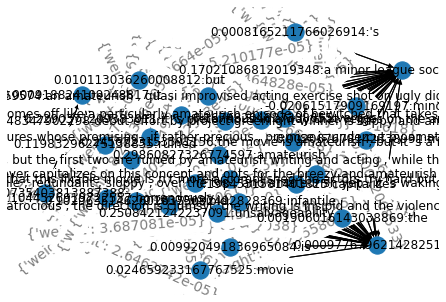

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.22),1,0.33,"the movie is amateurish , but it 's a minor treat"


In [39]:
interpret_sentence(3)

In [26]:
adj = sp.csr_matrix((data.edge_attr.cpu().numpy(), (data.edge_index[0].cpu().numpy(), data.edge_index[1].cpu().numpy())), shape=(data.x.shape[0], data.x.shape[0]))
adj = adj.toarray()

In [27]:
adj

array([[0.00698142, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.06519826, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.01496535, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00704269, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00634246,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00947753]], dtype=float32)